In [1]:
import torch
from torchvision import transforms
from datasets.noised import DemosaicDataset

In [2]:
train_data_dir = "/home/safin/datasets/CASIA-WebFace_linRGB/"
transform = transforms.Compose([
                 transforms.CenterCrop((112,96)),
                 transforms.ToTensor()
            ])
noised_dataset = DemosaicDataset(train_data_dir, transform) #, bayer_dir_name="noised_bayer_4lvl")

In [2]:
import os

gpu_id = 1
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu_id)

In [3]:
import torchvision
class Dataset_w_dirs(torchvision.datasets.ImageFolder):
    '''
    '''
    def __init__(self, dirs, transform=None):
        super(Dataset_w_dirs, self).__init__(dirs, transform)


    def __getitem__(self, index):
        '''
        Args:
            index: Index of the triplet or the matches - not of a single image
        Returns:
        '''

        def transform(img_path):
            """Convert image into numpy array and apply transformation
               Doing this so that it is consistent with all other datasets
               to return a PIL Image.
            """

            img = self.loader(img_path)
            
            if self.transform is not None:
                return self.transform(img)
            return img

        img_path, class_id = self.imgs[index]
        img = transform(img_path)
            
        return img, class_id, os.path.relpath(img_path, self.root)

In [4]:
import torchvision
from torchvision import transforms
transform = transforms.Compose([
                transforms.CenterCrop((112,96)),
                transforms.ToTensor(),
            ])

bayer_noised_data_dir = "/home/safin/datasets/CASIA-WebFace_linRGB/noised_bayer/"
dataset_bayer_noised_val = Dataset_w_dirs(bayer_noised_data_dir, transform=transform)

batch_size = 128
dataloader = torch.utils.data.dataloader.DataLoader(dataset_bayer_noised_val, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=12)

In [5]:
import tqdm
import queue
import threading
from PIL import Image
import numpy as np

num_worker_threads = 10

q_denoised = queue.Queue()
# q_noised = queue.Queue()
threads_denoised = []
# threads_noised = []

def do_work(img, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    Image.fromarray(img.clip(0,255).astype(np.uint8)).save(path)

class ImageSaver(threading.Thread):
    def __init__(self, q, output_path):
        threading.Thread.__init__(self)
        self.q = q
        self.output_path = output_path
        
    def run(self):
        while True:
            item = self.q.get()
            if item is None:
                break
            img, path = item
            path = os.path.join(self.output_path, path)
            do_work(img, path)
            self.q.task_done()

In [6]:
from MMNet_TBPTT import *
from networks.denoise.pydl import ResNet_Den
import torch 
from utils import freeze_model

denoiser = ResNet_Den(5, weightnorm=True)
denoiser = denoiser.cuda()
freeze_model(denoiser)

max_iter = 5
mmnet = MMNet(denoiser, max_iter=max_iter)
# mmnet_ckpt_path = "/home/safin/ms-thesis/ckpt/joint_15.04_dnfr/denoiser/weights_10"
# mmnet_ckpt_path = "/home/safin/FaceReID/ckpt/mmnet_5it_26.05_2/mmnet/weights_250"
# mmnet_ckpt_path = "/home/safin/ms-thesis/ckpt/20.04_resdnet_5it/denoiser/weights_200"
mmnet_ckpt_path = "/home/safin/FaceReID/ckpt/mmnet_29.05_10lvl/mmnet/weights_250"
# mmnet_ckpt_path = "/home/safin/FaceReID/ckpt/mmnet_5it_26.05_3/mmnet/weights_20"

mmnet_ckpt_path = "/home/safin/FaceReID/ckpt/mmnet_31.05_4lvl/mmnet/weights_9"
mmnet.load_state_dict(torch.load(mmnet_ckpt_path, map_location=lambda storage, loc: storage))
mmnet = mmnet.cuda()

In [6]:
from transforms.conversions import linrgb_to_srgb, bilinear, srgb_to_linrgb
from transforms.noising import realistic_noise

In [22]:
def generate_mask(im_shape, pattern='RGGB'):
    if pattern == 'RGGB':
        # pattern RGGB
        r_mask = torch.zeros(im_shape)
        r_mask[0::2, 0::2] = 1

        g_mask = torch.zeros(im_shape)
        g_mask[::2, 1::2] = 1
        g_mask[1::2, ::2] = 1

        b_mask = torch.zeros(im_shape)
        b_mask[1::2, 1::2] = 1

        mask = torch.zeros(im_shape + (3,))
        mask[:, :, 0] = r_mask
        mask[:, :, 1] = g_mask
        mask[:, :, 2] = b_mask
        
        return mask
M = generate_mask((112, 96), pattern='RGGB').permute(2,0,1).unsqueeze(0).cuda()

In [68]:
imgs_bayer_noisy.max()/0.6

tensor(120.0000)

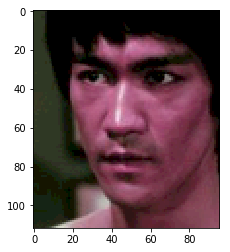

In [159]:
idx=11
plt.imshow(linrgb_to_srgb(noised_dataset[idx][1].permute(1,2,0).data.numpy()/255)/0.6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


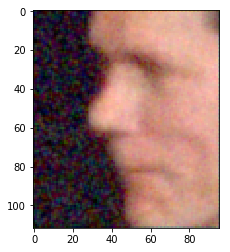

In [171]:
idx = 510
plt.imshow(linrgb_to_srgb(bilinear(noised_dataset[idx][0].unsqueeze(0)).squeeze(0).permute(1,2,0).data.numpy()/255)/0.6)

In [126]:
plt.imshow(linrgb_to_srgb(noised_dataset[img_idx][1].permute(1,2,0))/0.6)

tensor(79.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


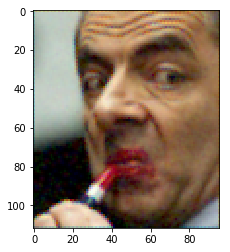

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


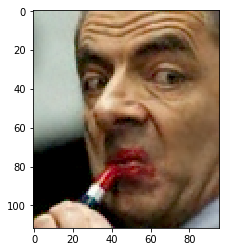

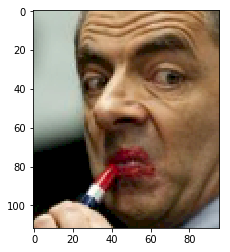

In [146]:
img_idx = 307
imgs_bayer_noisy, gt_linrgb, _ = noised_dataset[img_idx]
out = mmnet.forward_all_iter(imgs_bayer_noisy.unsqueeze(0).cuda(), M, init=False, noise_estimation=True).cpu()
out = out/255
out = out.permute(0,2,3,1)
cur_img = out[0].data.numpy()
cur_img = linrgb_to_srgb(cur_img)
plt.imshow(linrgb_to_srgb(bilinear(imgs_bayer_noisy.unsqueeze(0)/255).squeeze(0)).permute(1,2,0)/0.6)
plt.show()
plt.imshow(cur_img/0.6)
plt.show()
plt.imshow(linrgb_to_srgb(gt_linrgb.permute(1,2,0)/255)/0.6)

In [7]:
from transforms.noising import realistic_noise
def generate_mask(im_shape, pattern='RGGB'):
    if pattern == 'RGGB':
        # pattern RGGB
        r_mask = torch.zeros(im_shape)
        r_mask[0::2, 0::2] = 1

        g_mask = torch.zeros(im_shape)
        g_mask[::2, 1::2] = 1
        g_mask[1::2, ::2] = 1

        b_mask = torch.zeros(im_shape)
        b_mask[1::2, 1::2] = 1

        mask = torch.zeros((3,) + im_shape)
        mask[0, :, :] = r_mask
        mask[1, :, :] = g_mask
        mask[2, :, :] = b_mask
        return mask

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
from networks.denoise.dncnn import DnCNN
import torch

dncnn = DnCNN(image_channels=3)
dncnn_ckpt_path = "/home/safin/FaceReID/ckpt/dncnn_02.06/dncnn/weights_225"
# dncnn = DnCNN(3)
# dncnn_ckpt_path = "/home/safin/FaceReID/ckpt/dncnn_02.06_mse_2/dncnn/weights_7"
dncnn.load_state_dict(torch.load(dncnn_ckpt_path, map_location=lambda storage, loc: storage))
dncnn = dncnn.cuda()
dncnn.eval()

img_idx = 12
gt = linrgb_to_srgb(noised_dataset[img_idx][1]/255)/0.6
img = gt
img = img*0.6
img = srgb_to_linrgb(img)
c, h, w = img.shape
raw_img = generate_mask((h,w))*img

a = 0.15
b = 0.15
noised_raw = torch.from_numpy(realistic_noise(raw_img, a, b)).float()
noised = linrgb_to_srgb(bilinear(noised_raw.unsqueeze(0)).squeeze(0))/0.6
noised = noised.clamp(0,1)
plt.imshow((255*noised.permute(1,2,0)).numpy().astype(np.uint8))


NameError: name 'noised_dataset' is not defined

In [90]:
import torch.nn as nn

denoise_criterion = nn.MSELoss(size_average=False)
denoise_criterion((noised-gt),dncnn_out)

tensor(890.9258)

25.03722381591797

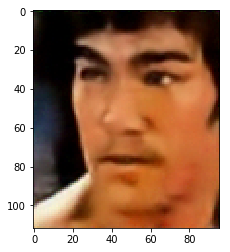

In [11]:
dncnn_out = dncnn(noised.unsqueeze(0).cuda()).squeeze(0).data.cpu()
denoised = (dncnn_out).clamp(0,1)
plt.imshow(denoised.permute(1,2,0))
float(PSNR(denoised.unsqueeze(0), gt.unsqueeze(0)).mean())

In [ ]:
for i in range(num_worker_threads):
    t = ImageSaver(q_denoised, "/home/safin/datasets/CASIA-WebFace_linRGB/dncnn_output/")
    t.start()
    threads_denoised.append(t)
    
from utils import freeze_model
freeze_model(dncnn)
dncnn.eval()
dncnn.train(False)

import time

t_start = time.time()
for batch_idx, sample in tqdm.tqdm_notebook(enumerate(dataloader)):
    noised, _, paths = sample
    noised = noised.cuda()
    noised = linrgb_to_srgb(bilinear(noised))/0.6
    denoised = dncnn(noised)

    for t in zip(denoised.permute(0, 2, 3, 1).cpu().data.numpy(), paths):
        q_denoised.put_nowait(t)


    
q_denoised.join()
for i in range(num_worker_threads):
    q_denoised.put(None)

    
for t in threads_denoised:
    t.join()


t_end = time.time()
print(t_end-t_start)

with open("done.txt", "w") as f:
    f.write("done\n")

7.554118633270264

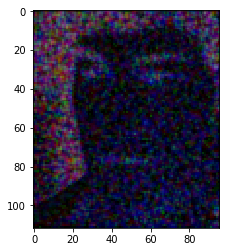

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
from loss import PSNR

dncnn_out = dncnn(noised.unsqueeze(0).cuda()).squeeze(0).data.cpu()
denoised = (noised-dncnn_out).clamp(0,1)
plt.imshow(denoised.permute(1,2,0))
float(PSNR(denoised.unsqueeze(0), gt.unsqueeze(0)).mean())

In [84]:
sig_read_linspace = np.linspace(-3,-1.5,4)
sig_shot_linspace = np.linspace(-2,-1,4)

sig_read = sig_read_linspace[3]
sig_shot = sig_shot_linspace[2]
a = np.power(10., sig_read)
b = np.power(10., sig_shot)

In [85]:
a,b 

(0.03162277660168379, 0.046415888336127774)

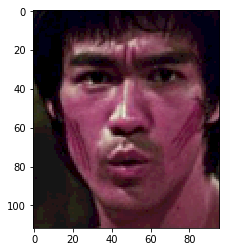

In [33]:
plt.imshow(gt.permute(1,2,0))

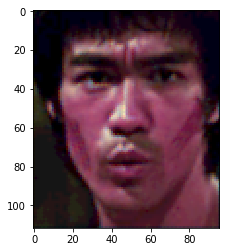

In [42]:
idx = 10
plt.imshow((linrgb_to_srgb(bilinear(noised_dataset[idx][0].unsqueeze(0)).squeeze(0)/255)/0.6).permute(1,2,0))

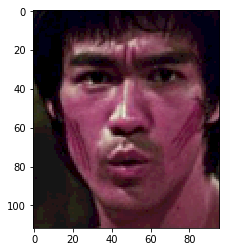

In [36]:
idx = 10
plt.imshow((linrgb_to_srgb(noised_dataset[idx][1]/255)/0.6).permute(1,2,0))

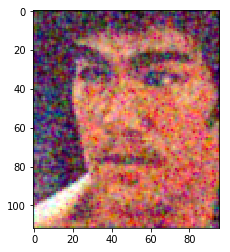

In [9]:
idx = 12
noised = linrgb_to_srgb(bilinear(noised_dataset[idx][0].unsqueeze(0)).squeeze(0)/255)/0.6
noised = noised.clamp(0,1)
plt.imshow(noised.permute(1,2,0))

In [35]:
imgs_bayer_noisy = dataset_bayer_noised_val[0][0]
out = mmnet.forward_all_iter(255*imgs_bayer_noisy.unsqueeze(0).cuda(), M, init=False, noise_estimation=True).cpu()

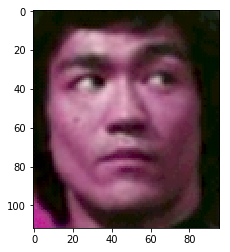

In [40]:
cur_img = out[0].data.numpy()
cur_img = linrgb_to_srgb(cur_img)
plt.imshow(cur_img/0.6)

In [20]:
sig_read_linspace = np.linspace(-3,-1.5,4)
sig_shot_linspace = np.linspace(-2,-1,4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


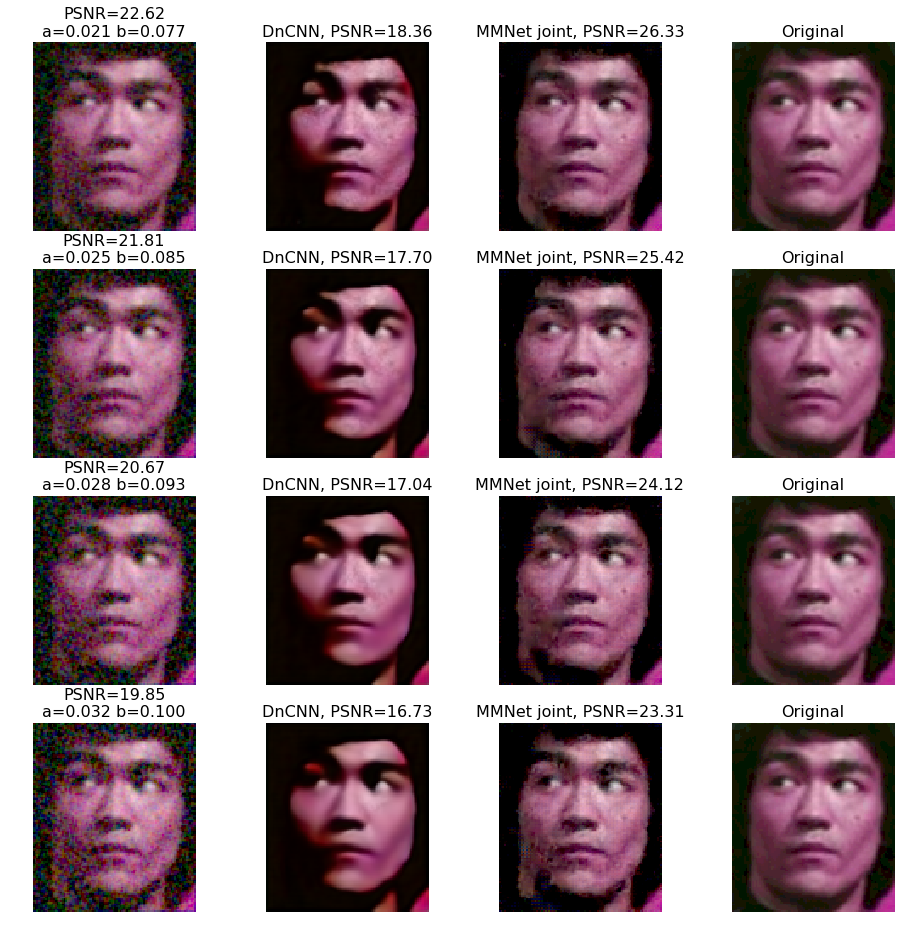

In [25]:
gt = linrgb_to_srgb(noised_dataset[0][1]/255)/0.6
img = gt
img = img*0.6
img = srgb_to_linrgb(img)
c, h, w = img.shape
raw_img = generate_mask((h,w))*img

from loss import PSNR

fig_w = 16
fig_h = 16
fig=plt.figure(figsize=(fig_w, fig_h))
fontsize_global = 16
rows = 4
columns = 4


sig_read_ = np.power(10., sig_read_linspace)
sig_shot_ = np.power(10., sig_shot_linspace)
a = (sig_shot_linspace[0] - sig_shot_linspace[-1])/( sig_read_linspace[0] - sig_read_linspace[-1])
b = np.power(10., sig_shot_linspace[0]-a*sig_read_linspace[0])
sig_read_ = np.linspace(sig_read_[0], sig_read_[-1], 10)
sig_shot_ = np.power(sig_read_, a)*b

sig_read_ = sig_read_[-4:]
sig_shot_ = sig_shot_[-4:]



i = 0
for a, b in zip(sig_read_, sig_shot_):   
    noised_raw = torch.from_numpy(realistic_noise(raw_img, a, b)).float()
    noised = linrgb_to_srgb(bilinear(noised_raw.unsqueeze(0)).squeeze(0))/0.6
    noised = noised.clamp(0,1)
    fig.add_subplot(rows, columns, 1+i*columns)
    plt.imshow(noised.permute(1,2,0))
    plt.axis('off')
    cur_psnr = PSNR(noised.unsqueeze(0), gt.unsqueeze(0))
    plt.title("PSNR=%.2f\na=%.3f b=%.3f" % (cur_psnr.item(), a, b), fontsize = fontsize_global)
       
    out = dncnn(noised.unsqueeze(0).cuda()).cpu().detach()
    fig.add_subplot(rows, columns, 1+i*columns+1)
    plt.imshow(out.squeeze(0).permute(1,2,0))
    plt.axis('off')
    cur_psnr = PSNR(out.unsqueeze(0), gt.unsqueeze(0))
    plt.title("DnCNN, PSNR=%.2f" % cur_psnr.item(), fontsize = fontsize_global)

#     out = mmnet_plain.forward_all_iter(255*noised_raw.unsqueeze(0).cuda(), M, init=False, noise_estimation=True).cpu().detach()
#     out = out.squeeze(0)/255
#     out = linrgb_to_srgb(out)/0.6
#     fig.add_subplot(rows, columns, 1+i*columns+1)
#     plt.imshow(out.permute(1,2,0))
#     plt.axis('off')
#     cur_psnr = PSNR(out.unsqueeze(0), gt.unsqueeze(0))
#     plt.title("MMNet, PSNR=%.2f" % cur_psnr.item(), fontsize = fontsize_global)
    
    out = mmnet.forward_all_iter(255*noised_raw.unsqueeze(0).cuda(), M, init=False, noise_estimation=True).cpu().detach()
    out = out.squeeze(0)/255
    out = linrgb_to_srgb(out)/0.6
    fig.add_subplot(rows, columns, 1+i*columns+2)
    plt.imshow(out.permute(1,2,0))
    plt.axis('off')
    cur_psnr = PSNR(out.unsqueeze(0), gt.unsqueeze(0))
    plt.title("MMNet joint, PSNR=%.2f" % cur_psnr.item(), fontsize = fontsize_global)

    fig.add_subplot(rows, columns, 1+i*columns+3)
    plt.imshow(gt.permute(1,2,0))
    plt.axis('off')
    plt.title("Original", fontsize = fontsize_global)
    
    i+=1

In [35]:
from networks.denoise.dncnn import DnCNN

dncnn = DnCNN(image_channels=3)
dncnn_ckpt_path = "/home/safin/FaceReID/ckpt/dncnn_30.05/dncnn/weights_250"

dncnn_ckpt_path = "/home/safin/FaceReID/ckpt/dncnn_31.05/dncnn/weights_36"
# mmnet_ckpt_path = "/home/safin/FaceReID/ckpt/mmnet_5it_26.05_3/mmnet/weights_20"
dncnn.load_state_dict(torch.load(dncnn_ckpt_path, map_location=lambda storage, loc: storage))
dncnn = dncnn.cuda()

denoiser_plain = ResNet_Den(5, weightnorm=True)
denoiser_plain = denoiser_plain.cuda()
freeze_model(denoiser)

max_iter = 5
mmnet_plain = MMNet(denoiser_plain, max_iter=max_iter)
mmnet_plain_ckpt_path = "/home/safin/FaceReID/ckpt/mmnet_5it_26.05_3/mmnet/weights_20"
mmnet_plain.load_state_dict(torch.load(mmnet_plain_ckpt_path, map_location=lambda storage, loc: storage))
mmnet_plain = mmnet_plain.cuda()

denoiser = ResNet_Den(5, weightnorm=True)
denoiser = denoiser.cuda()
freeze_model(denoiser)

max_iter = 5
mmnet = MMNet(denoiser, max_iter=max_iter)
mmnet_ckpt_path = "/home/safin/FaceReID/ckpt/joint_27.05_faceid-fr/mmnet/weights_19"
mmnet.load_state_dict(torch.load(mmnet_ckpt_path, map_location=lambda storage, loc: storage))
mmnet = mmnet.cuda()

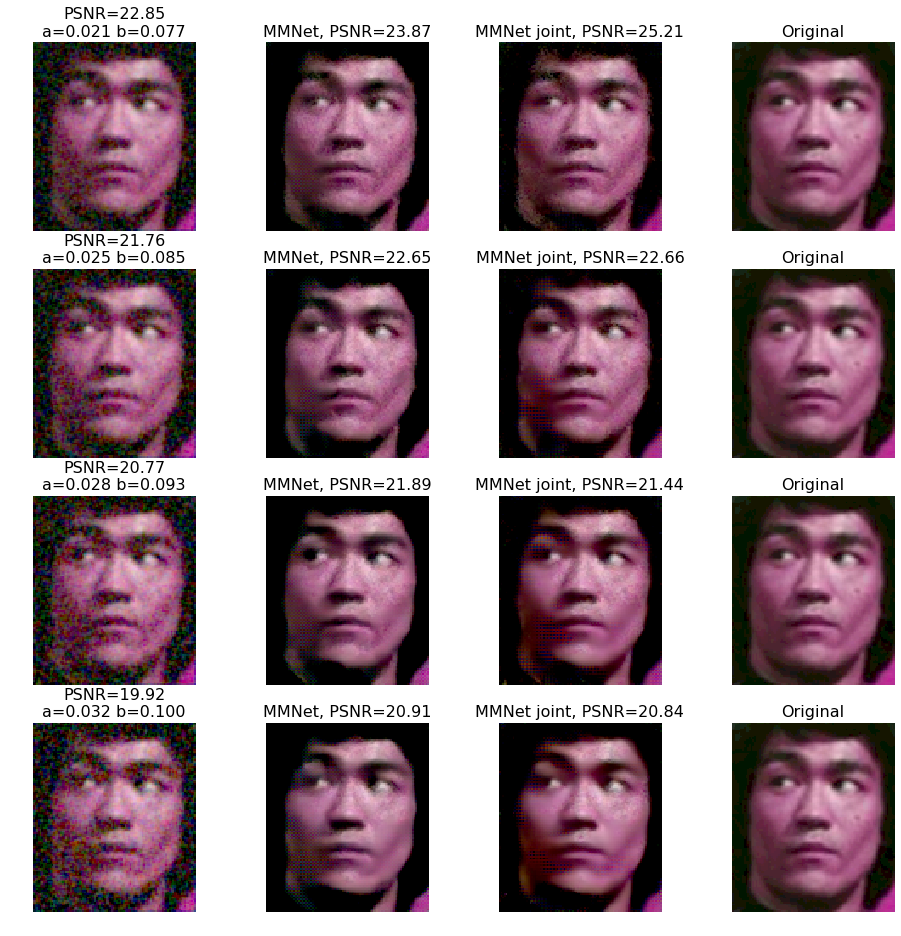

In [180]:
gt = linrgb_to_srgb(noised_dataset[0][1]/255)/0.6
img = gt
img = img*0.6
img = srgb_to_linrgb(img)
c, h, w = img.shape
raw_img = generate_mask((h,w))*img

from loss import PSNR

fig_w = 16
fig_h = 16
fig=plt.figure(figsize=(fig_w, fig_h))
fontsize_global = 16
rows = 4
columns = 4


sig_read_ = np.power(10., sig_read_linspace)
sig_shot_ = np.power(10., sig_shot_linspace)
a = (sig_shot_linspace[0] - sig_shot_linspace[-1])/( sig_read_linspace[0] - sig_read_linspace[-1])
b = np.power(10., sig_shot_linspace[0]-a*sig_read_linspace[0])
sig_read_ = np.linspace(sig_read_[0], sig_read_[-1], 10)
sig_shot_ = np.power(sig_read_, a)*b

sig_read_ = sig_read_[-4:]
sig_shot_ = sig_shot_[-4:]



i = 0
for a, b in zip(sig_read_, sig_shot_):   
    noised_raw = torch.from_numpy(realistic_noise(raw_img, a, b)).float()
    noised = linrgb_to_srgb(bilinear(noised_raw.unsqueeze(0)).squeeze(0))/0.6
    noised = noised.clamp(0,1)
    fig.add_subplot(rows, columns, 1+i*columns)
    plt.imshow(noised.permute(1,2,0))
    plt.axis('off')
    cur_psnr = PSNR(noised.unsqueeze(0), gt.unsqueeze(0))
    plt.title("PSNR=%.2f\na=%.3f b=%.3f" % (cur_psnr.item(), a, b), fontsize = fontsize_global)
       
    out = dncnn(noised.unsqueeze(0).cuda()).cpu().detach()
    fig.add_subplot(rows, columns, 1+i*columns+1)
    plt.imshow(out.permute(1,2,0))
    plt.axis('off')
    cur_psnr = PSNR(out.unsqueeze(0), gt.unsqueeze(0))
    plt.title("DnCNN, PSNR=%.2f" % cur_psnr.item(), fontsize = fontsize_global)

#     out = mmnet_plain.forward_all_iter(255*noised_raw.unsqueeze(0).cuda(), M, init=False, noise_estimation=True).cpu().detach()
#     out = out.squeeze(0)/255
#     out = linrgb_to_srgb(out)/0.6
#     fig.add_subplot(rows, columns, 1+i*columns+1)
#     plt.imshow(out.permute(1,2,0))
#     plt.axis('off')
#     cur_psnr = PSNR(out.unsqueeze(0), gt.unsqueeze(0))
#     plt.title("MMNet, PSNR=%.2f" % cur_psnr.item(), fontsize = fontsize_global)
    
    out = mmnet.forward_all_iter(255*noised_raw.unsqueeze(0).cuda(), M, init=False, noise_estimation=True).cpu().detach()
    out = out.squeeze(0)/255
    out = linrgb_to_srgb(out)/0.6
    fig.add_subplot(rows, columns, 1+i*columns+2)
    plt.imshow(out.permute(1,2,0))
    plt.axis('off')
    cur_psnr = PSNR(out.unsqueeze(0), gt.unsqueeze(0))
    plt.title("MMNet joint, PSNR=%.2f" % cur_psnr.item(), fontsize = fontsize_global)

    fig.add_subplot(rows, columns, 1+i*columns+3)
    plt.imshow(gt.permute(1,2,0))
    plt.axis('off')
    plt.title("Original", fontsize = fontsize_global)
    
    i+=1

In [110]:
import torchvision
transform = transforms.Compose([
                transforms.CenterCrop((112,96)),
                transforms.ToTensor(),
            ])

data_dir = "/home/safin/datasets/CASIA-WebFace_linRGB/noised_bayer_10lvl/"
dataset = torchvision.datasets.ImageFolder(data_dir, transform=transform)

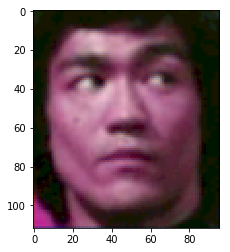

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


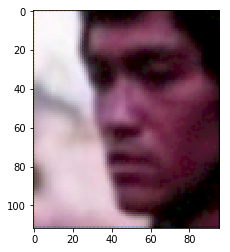

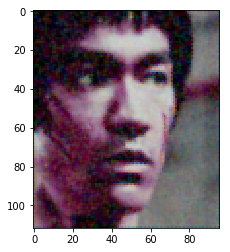

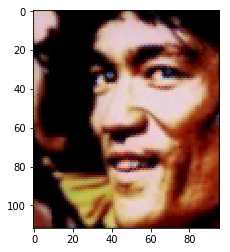

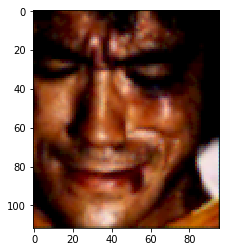

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


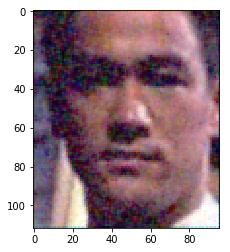

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


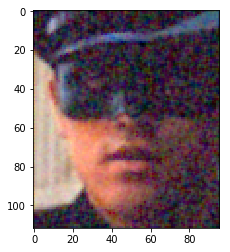

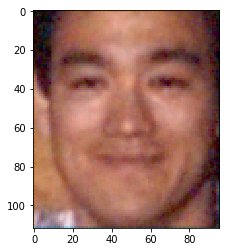

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


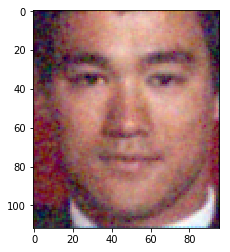

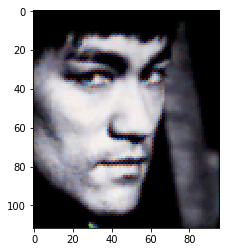

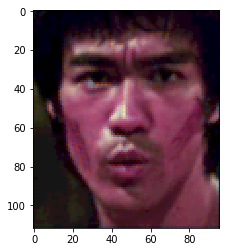

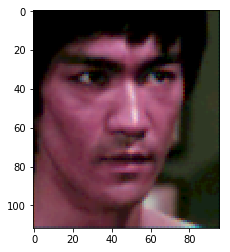

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


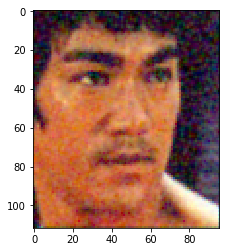

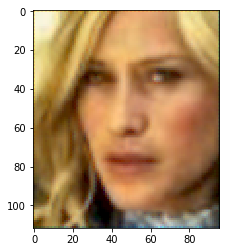

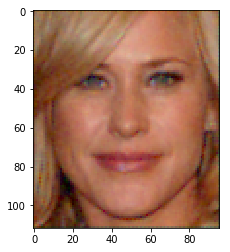

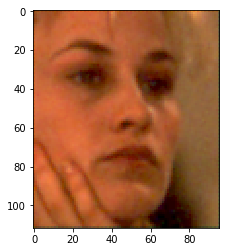

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


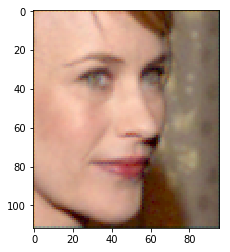

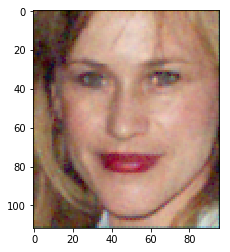

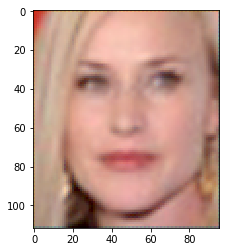

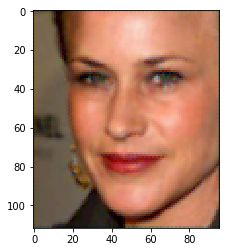

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


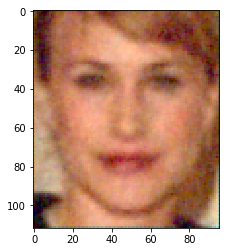

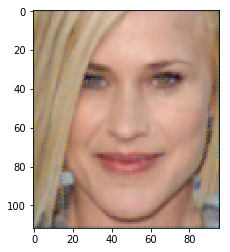

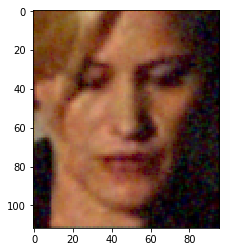

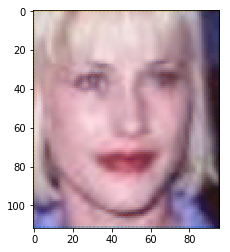

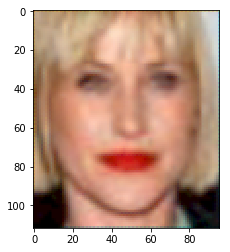

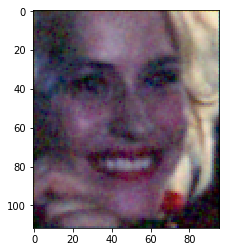

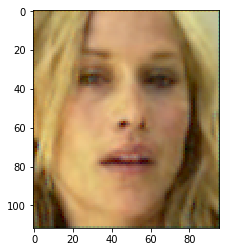

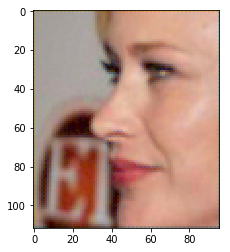

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


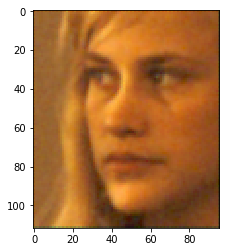

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


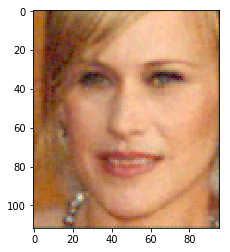

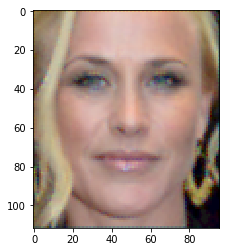

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


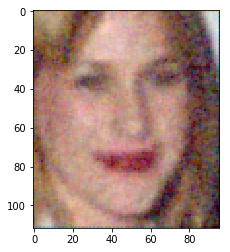

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


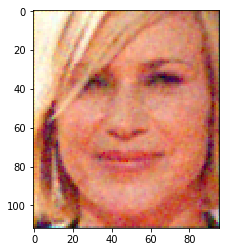

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


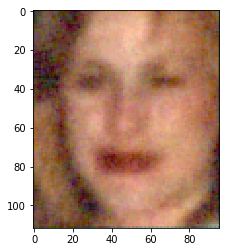

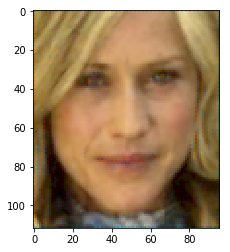

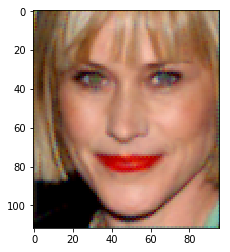

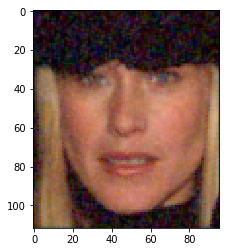

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


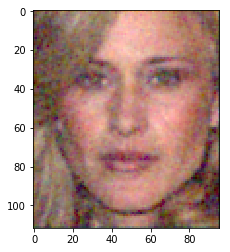

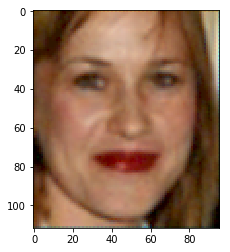

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


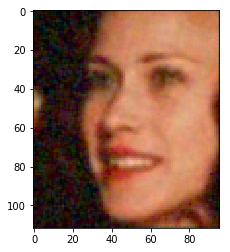

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


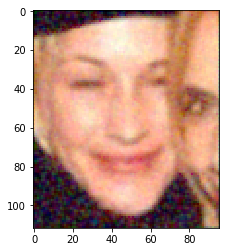

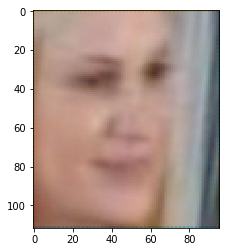

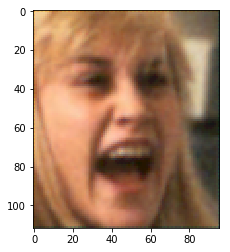

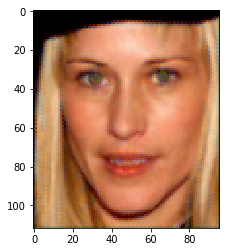

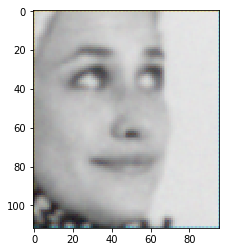

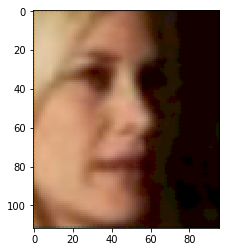

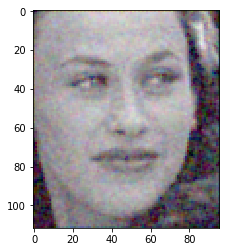

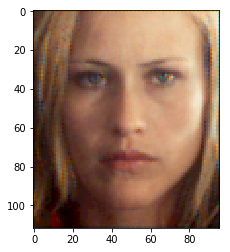

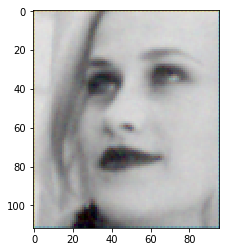

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


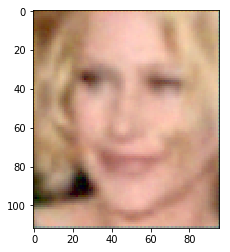

In [120]:
for i in range(50):
    plt.imshow(linrgb_to_srgb(bilinear(dataset[i][0].unsqueeze(0)).squeeze(0)).permute(1,2,0)/0.6)
    plt.show()

In [ ]:
from transforms.noising import realistic_noise

In [7]:
import torchvision
from torchvision import transforms
transform = transforms.Compose([
                transforms.CenterCrop((112,96)),
                transforms.ToTensor(),
            ])

bayer_noised_data_dir = "/home/safin/datasets/CASIA-WebFace_linRGB/noised_bayer/"
dataset_bayer_noised_val = torchvision.datasets.ImageFolder(bayer_noised_data_dir, transform=transform)

In [13]:
imgs_bayer_noisy = dataset_bayer_noised_val[0][0]
out = mmnet.forward_all_iter(255*imgs_bayer_noisy.unsqueeze(0).cuda(), M, init=False, noise_estimation=True).cpu()

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

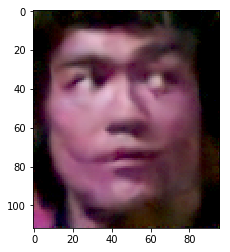

In [15]:
out = out.squeeze(0).permute(1,2,0)
out = out.data.numpy()/255
plt.imshow(linrgb_to_srgb(out)/0.6)

In [12]:
out.shape

(112, 96, 3)

In [11]:
out.shape

torch.Size([1, 3, 112, 96])

In [1]:
import torch
import numpy as np

In [2]:
from networks.faceid.sphereface import sphere20a
from networks.denoise.pydl import ResDNet
from networks.denoise.pydl import UDNet
from networks.denoise.pydl import UDNetPA

In [3]:
#faceid = networks.sphereface.sphere20a()
# faceid = sphere20a()

In [2]:
import os

gpu_id = 2
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu_id)

In [5]:
# denoiser = ResDNet(kernel_size = (5, 5),
#                 input_channels = 3,
#                 output_features = 32,
#                 rpa_depth = 7,
#                 shortcut=(False,True))

In [6]:
# denoiser = UDNetPA(kernel_size = (5, 5),
#                 input_channels = 3,
#                 output_features = 32,
#                 rpa_depth = 7,
#                 shortcut=(False,True))
# denoiser_ckpt = torch.load("/home/safin/ckpt/1st_udnetpa/weigths_31")
# denoiser.load_state_dict(denoiser_ckpt)
# denoiser.cuda()

UDNetPA(depth = 7, convWeightSharing = True, shortcut = (False, True, True, True, True, True, True))

In [3]:
from MMNet_TBPTT import *
from networks.denoise.pydl import ResNet_Den
import torch 
from utils import freeze_model

denoiser = ResNet_Den(5, weightnorm=True)
denoiser = denoiser.cuda()
freeze_model(denoiser)

max_iter = 5
mmnet = MMNet(denoiser, max_iter=max_iter)
# mmnet_ckpt_path = "/home/safin/ms-thesis/ckpt/joint_15.04_dnfr/denoiser/weights_10"
mmnet_ckpt_path = "/home/safin/FaceReID/ckpt/mmnet_5it_26.05_2/mmnet/weights_250"
# mmnet_ckpt_path = "/home/safin/ms-thesis/ckpt/20.04_resdnet_5it/denoiser/weights_200"
mmnet_ckpt_path = "/home/safin/FaceReID/ckpt/mmnet_5it_26.05_3/mmnet/weights_299"
mmnet.load_state_dict(torch.load(mmnet_ckpt_path, map_location=lambda storage, loc: storage))
mmnet = mmnet.cuda()

torch.backends.cudnn.benchmark = True 

In [6]:
import torchvision
class Dataset_w_dirs(torchvision.datasets.ImageFolder):
    '''
    '''
    def __init__(self, dirs, transform=None):
        super(Dataset_w_dirs, self).__init__(dirs, transform)


    def __getitem__(self, index):
        '''
        Args:
            index: Index of the triplet or the matches - not of a single image
        Returns:
        '''

        def transform(img_path):
            """Convert image into numpy array and apply transformation
               Doing this so that it is consistent with all other datasets
               to return a PIL Image.
            """

            img = self.loader(img_path)
            
            if self.transform is not None:
                return self.transform(img)
            return img

        img_path, class_id = self.imgs[index]
        img = transform(img_path)
            
        return img, class_id, os.path.relpath(img_path, self.root)

In [7]:
import torchvision
from torchvision import transforms
transform = transforms.Compose([
                transforms.CenterCrop((112,96)),
                transforms.ToTensor(),
            ])

bayer_noised_data_dir = "/home/safin/datasets/CASIA-WebFace_linRGB/noised_bayer/"
dataset_bayer_noised_val = Dataset_w_dirs(bayer_noised_data_dir, transform=transform)

batch_size = 16
dataloader = torch.utils.data.dataloader.DataLoader(dataset_bayer_noised_val, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=12)

In [8]:
import tqdm
import queue
import threading
from PIL import Image
import numpy as np

num_worker_threads = 10

q_denoised = queue.Queue()
# q_noised = queue.Queue()
threads_denoised = []
# threads_noised = []

def do_work(img, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    Image.fromarray(img.clip(0,255).astype(np.uint8)).save(path)

class ImageSaver(threading.Thread):
    def __init__(self, q, output_path):
        threading.Thread.__init__(self)
        self.q = q
        self.output_path = output_path
        
    def run(self):
        while True:
            item = self.q.get()
            if item is None:
                break
            img, path = item
            path = os.path.join(self.output_path, path)
            do_work(img, path)
            self.q.task_done()

In [9]:
def generate_mask(im_shape, pattern='RGGB'):
    if pattern == 'RGGB':
        # pattern RGGB
        r_mask = torch.zeros(im_shape)
        r_mask[0::2, 0::2] = 1

        g_mask = torch.zeros(im_shape)
        g_mask[::2, 1::2] = 1
        g_mask[1::2, ::2] = 1

        b_mask = torch.zeros(im_shape)
        b_mask[1::2, 1::2] = 1

        mask = torch.zeros(im_shape + (3,))
        mask[:, :, 0] = r_mask
        mask[:, :, 1] = g_mask
        mask[:, :, 2] = b_mask
        
        return mask
M = generate_mask((112, 96), pattern='RGGB').permute(2,0,1).unsqueeze(0).cuda()

In [ ]:
for i in range(num_worker_threads):
    t = ImageSaver(q_denoised, "/home/safin/datasets/CASIA-WebFace_linRGB/mmnet_output/")
    t.start()
    threads_denoised.append(t)
    
from utils import freeze_model
freeze_model(mmnet)
mmnet.eval()
mmnet.train(False)

import time

t_start = time.time()
for batch_idx, sample in tqdm.tqdm_notebook(enumerate(dataloader)):
    noised, _, paths = sample
    noised = noised.cuda()
    denoised = mmnet.forward_all_iter(255*noised, M, init=False, noise_estimation=True)

    for t in zip(denoised.permute(0, 2, 3, 1).cpu().data.numpy(), paths):
        q_denoised.put_nowait(t)


    
q_denoised.join()
for i in range(num_worker_threads):
    q_denoised.put(None)

    
for t in threads_denoised:
    t.join()


t_end = time.time()
print(t_end-t_start)

with open("done.txt", "w") as f:
    f.write("done\n")

In [7]:
from datasets.noised import NoisedDataset

In [8]:
from torchvision import datasets, transforms

import random
class GaussianNoise(object):
    def __init__(self, std, mean=0, threshold = 0.5):
        self.std = std
        self.mean = mean
        self.threshold = threshold

    def __call__(self, img):
        if random.random() > self.threshold:
            return img
        
        if isinstance(self.std, list):
            std = np.random.choice(self.std)
        else:
            std = self.std
        return torch.clamp(img + torch.randn(*img.shape)*std + self.mean, 0, 1)
#         return img + torch.randn(*img.shape)*std + self.mean
#         return img + np.random.randn(*img.shape)*std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    

high_noise_std_arr = (np.arange(30, 55, 4)/255).tolist()

train_data_dir = "/home/safin/datasets/CASIA-WebFace/CASIA-WebFace-sphereface/"
transform = transforms.Compose([
                         transforms.RandomCrop((112,96)),
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor()
                     ])
noised_dataset = NoisedDataset(train_data_dir, transform=transform, noise_transform=GaussianNoise(std=high_noise_std_arr, threshold=0.7))

In [9]:
noised_dataset[0][1].shape

torch.Size([3, 112, 96])

In [9]:
import sys
sys.path.append("/home/safin/")
from pydl import utils as pydlutil

import torch.nn as nn
import torch.optim as optim

In [9]:
denoiser.forward.__code__

<code object forward at 0x7f76601f9300, file "/home/safin/ms-thesis/networks/denoise/pydl.py", line 127>

In [10]:
batch_size = 128
dataloader = torch.utils.data.dataloader.DataLoader(noised_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=12)

In [11]:
denoise_criterion = nn.L1Loss().cuda()
lr = 0.0005
optimizer = optim.Adam(denoiser.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-04)

batch_size = 128
batch_x = noised_dataset[0][0].repeat(batch_size,1,1,1)
batch_y = noised_dataset[0][1].repeat(batch_size,1,1,1)
for sample in dataloader:
    batch_x, batch_y, _ = sample
    data_x = batch_x.cuda()
    data_y = batch_y.cuda()
    data_x = data_x*255
    sigma = pydlutil.wmad_estimator(data_x)
    sigma = sigma.cuda()
    
    prediction = denoiser(data_x, sigma)
    loss = denoise_criterion(data_y, prediction)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

Process Process-2:
Process Process-8:
Process Process-3:
Process Process-4:
Process Process-10:
Process Process-12:
Process Process-9:
Process Process-1:
Process Process-7:
Process Process-11:
Process Process-5:
Process Process-6:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/safin/miniconda3/envs/py36ml/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/safin/miniconda3/envs/py36ml/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/safin/miniconda3/envs/py36ml/lib/python3.6/multiprocessing/process.py", line 258, in 

  File "/home/safin/miniconda3/envs/py36ml/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/safin/miniconda3/envs/py36ml/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/safin/miniconda3/envs/py36ml/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/safin/miniconda3/envs/py36ml/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/safin/miniconda3/envs/py36ml/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/safin/miniconda3/envs/py36ml/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/safin/miniconda3/envs/py36ml/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/safin/miniconda3/envs/py

KeyboardInterrupt: 

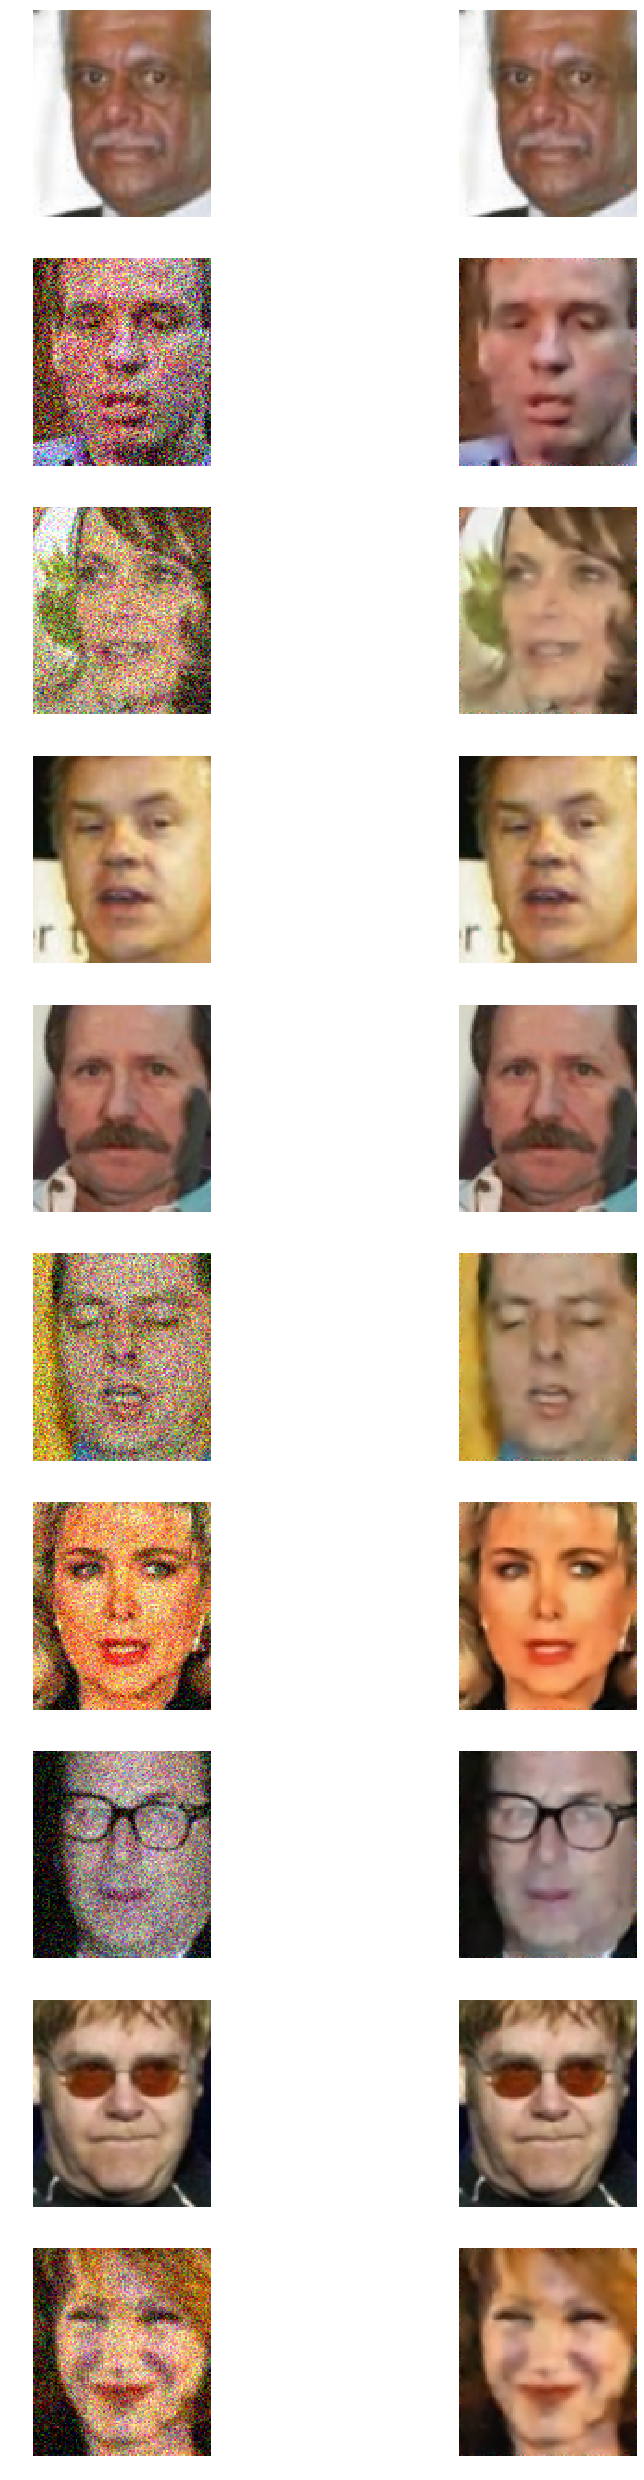

In [15]:
from datasets.lfw import LFWDataset
from transforms.noising import GaussianNoise

high_noise_std_arr = (np.arange(30, 55, 4)/255).tolist()

noise_transform = transforms.Compose([
                         transforms.ToTensor(),
                         GaussianNoise(high_noise_std_arr, clamp=[0,1])
                     ])

transform = noise_transform
lfw_data_dir = "/home/safin/datasets/lfw/lfw-sphereface/"
lfw_dataset = LFWDataset(lfw_data_dir, "/home/safin/datasets/lfw/pairsDevTrain.txt", transform, "png")
batch_size=10
dataloader_test = torch.utils.data.dataloader.DataLoader(lfw_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=12)

import sys
sys.path.append("/home/safin/")
from pydl import utils as pydlutil

for batch_idx, sample in enumerate(dataloader_test):
    data_x, data_y, _ = sample
    data_x, data_y = data_x.cuda(), data_y.cuda()
    data_x = data_x*255
    sigma = pydlutil.wmad_estimator(data_x)
    sigma = sigma.cuda()

    prediction = denoiser(data_x, sigma)
    break

noised = data_x.data.cpu().permute(0, 2, 3, 1).numpy()
prediction = prediction.data.cpu().permute(0, 2, 3, 1).numpy()

denoised = prediction.astype(np.uint8)
noised = noised.clip(0,255).astype(np.uint8)

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
def psnr(img1, img2, PIXEL_MAX):
    mse = np.mean( (img1.astype(np.float32) - img2.astype(np.float32)) ** 2 )
    if mse == 0:
        return np.inf
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

w = 14
h = 45

columns = 2
rows = batch_size
fig=plt.figure(figsize=(w, h))

for i in range(rows):
    fig.add_subplot(rows, columns, 1+i*columns)
    plt.imshow(noised[i])
    plt.axis('off')
    
    fig.add_subplot(rows, columns, 1+i*columns+1)
    plt.imshow(denoised[i])
    plt.axis('off')

In [18]:
((prediction-127.5)/128).max()

0.99609375

In [13]:
batch_size = 10
dataloader_test = torch.utils.data.dataloader.DataLoader(noised_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=16)

import sys
sys.path.append("/home/safin/")
from pydl import utils as pydlutil

for batch_idx, sample in enumerate(dataloader_test):
    noised, groundtruth, _ = sample
    noised, groundtruth = noised.cuda(), groundtruth.cuda()
    sigma = pydlutil.wmad_estimator(noised)
    sigma = sigma.cuda()
    prediction = denoiser(noised, sigma)
    break

In [14]:
noised = noised.data.cpu().permute(0, 2, 3, 1).numpy()
prediction = prediction.data.cpu().permute(0, 2, 3, 1).numpy()
groundtruth = groundtruth.data.cpu().permute(0, 2, 3, 1).numpy()

denoised = prediction.astype(np.uint8)
noised = noised.clip(0,255).astype(np.uint8)
groundtruth = groundtruth.astype(np.uint8)

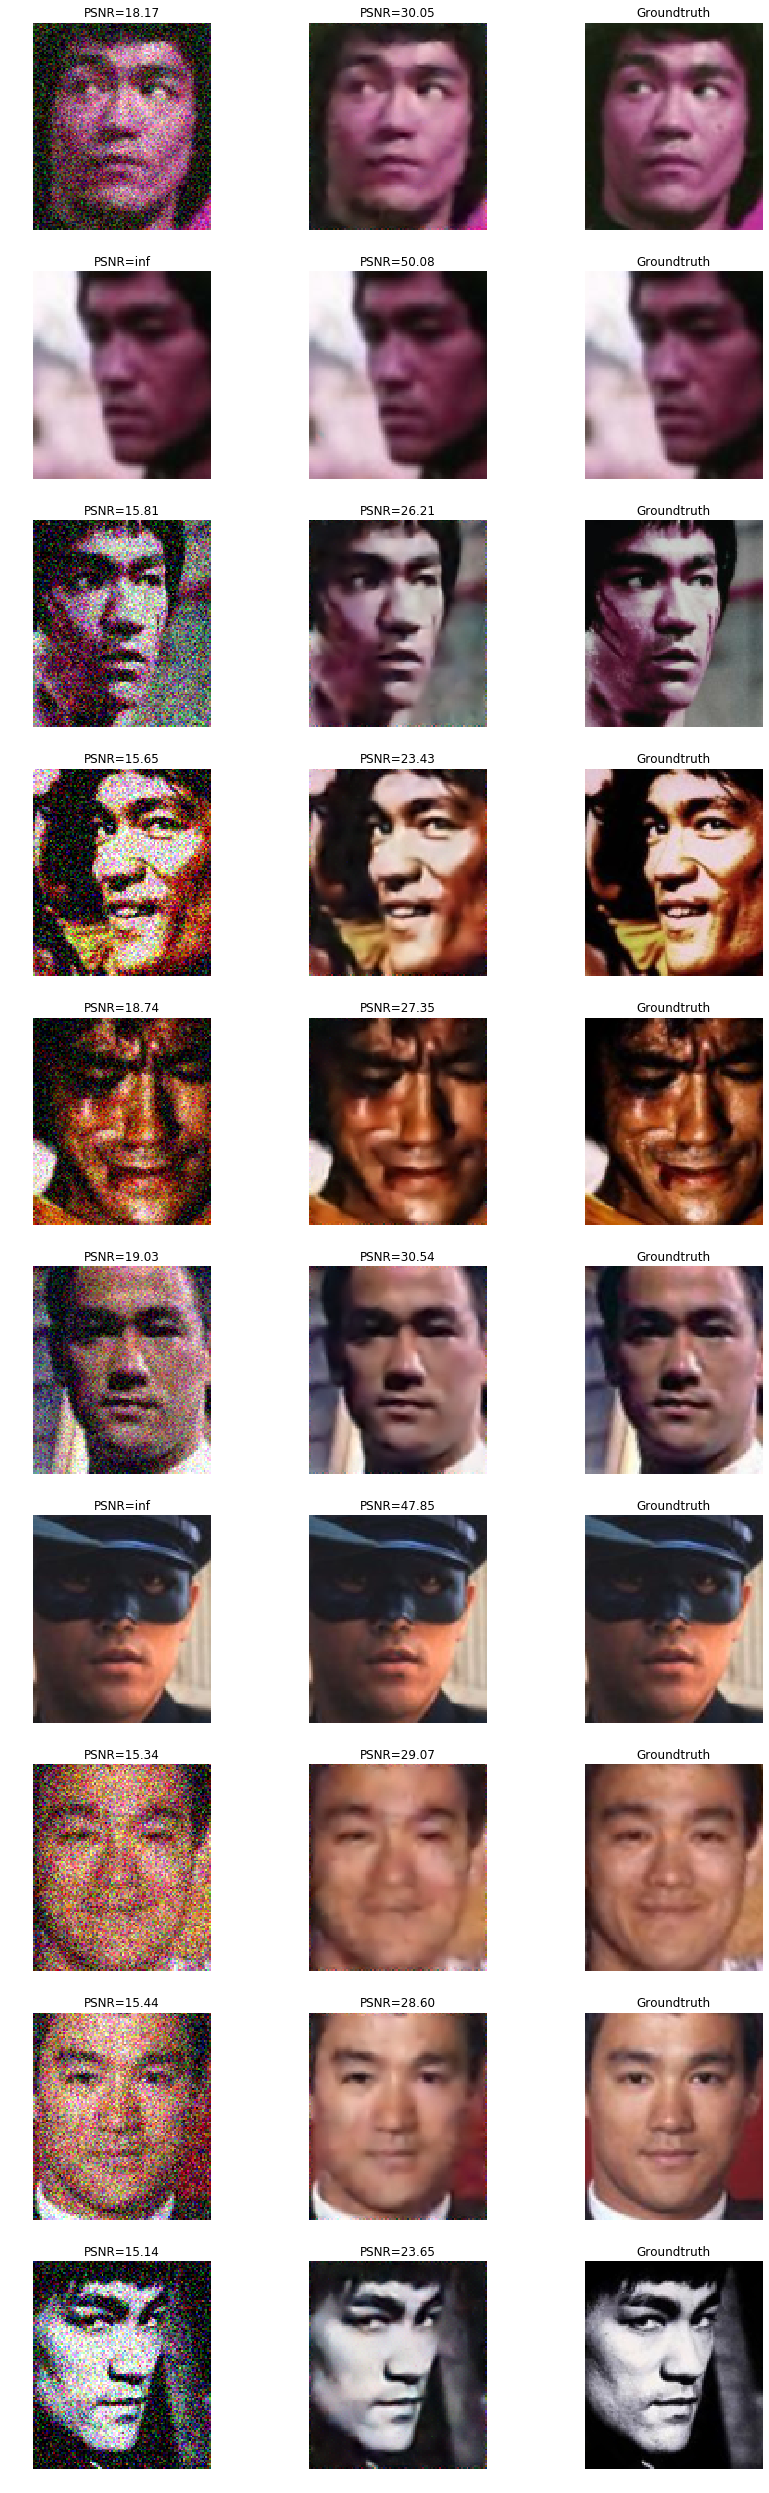

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
def psnr(img1, img2, PIXEL_MAX):
    mse = np.mean( (img1.astype(np.float32) - img2.astype(np.float32)) ** 2 )
    if mse == 0:
        return np.inf
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

w = 14
h = 45

columns = 3
rows = batch_size
fig=plt.figure(figsize=(w, h))

for i in range(rows):
    fig.add_subplot(rows, columns, 1+i*columns)
    plt.imshow(noised[i])
    plt.axis('off')
    noised_psnr = psnr(noised[i], groundtruth[i], PIXEL_MAX=255)
    plt.title("PSNR=%.2f" % noised_psnr)
    
    fig.add_subplot(rows, columns, 1+i*columns+1)
    plt.imshow(denoised[i])
    plt.axis('off')
    denoised_psnr = psnr(denoised[i], groundtruth[i], PIXEL_MAX=255)
    plt.title("PSNR=%.2f" % denoised_psnr)
       
    fig.add_subplot(rows, columns, 1+i*columns+2)
    plt.imshow(groundtruth[i])
    plt.axis('off')
    plt.title("Groundtruth")

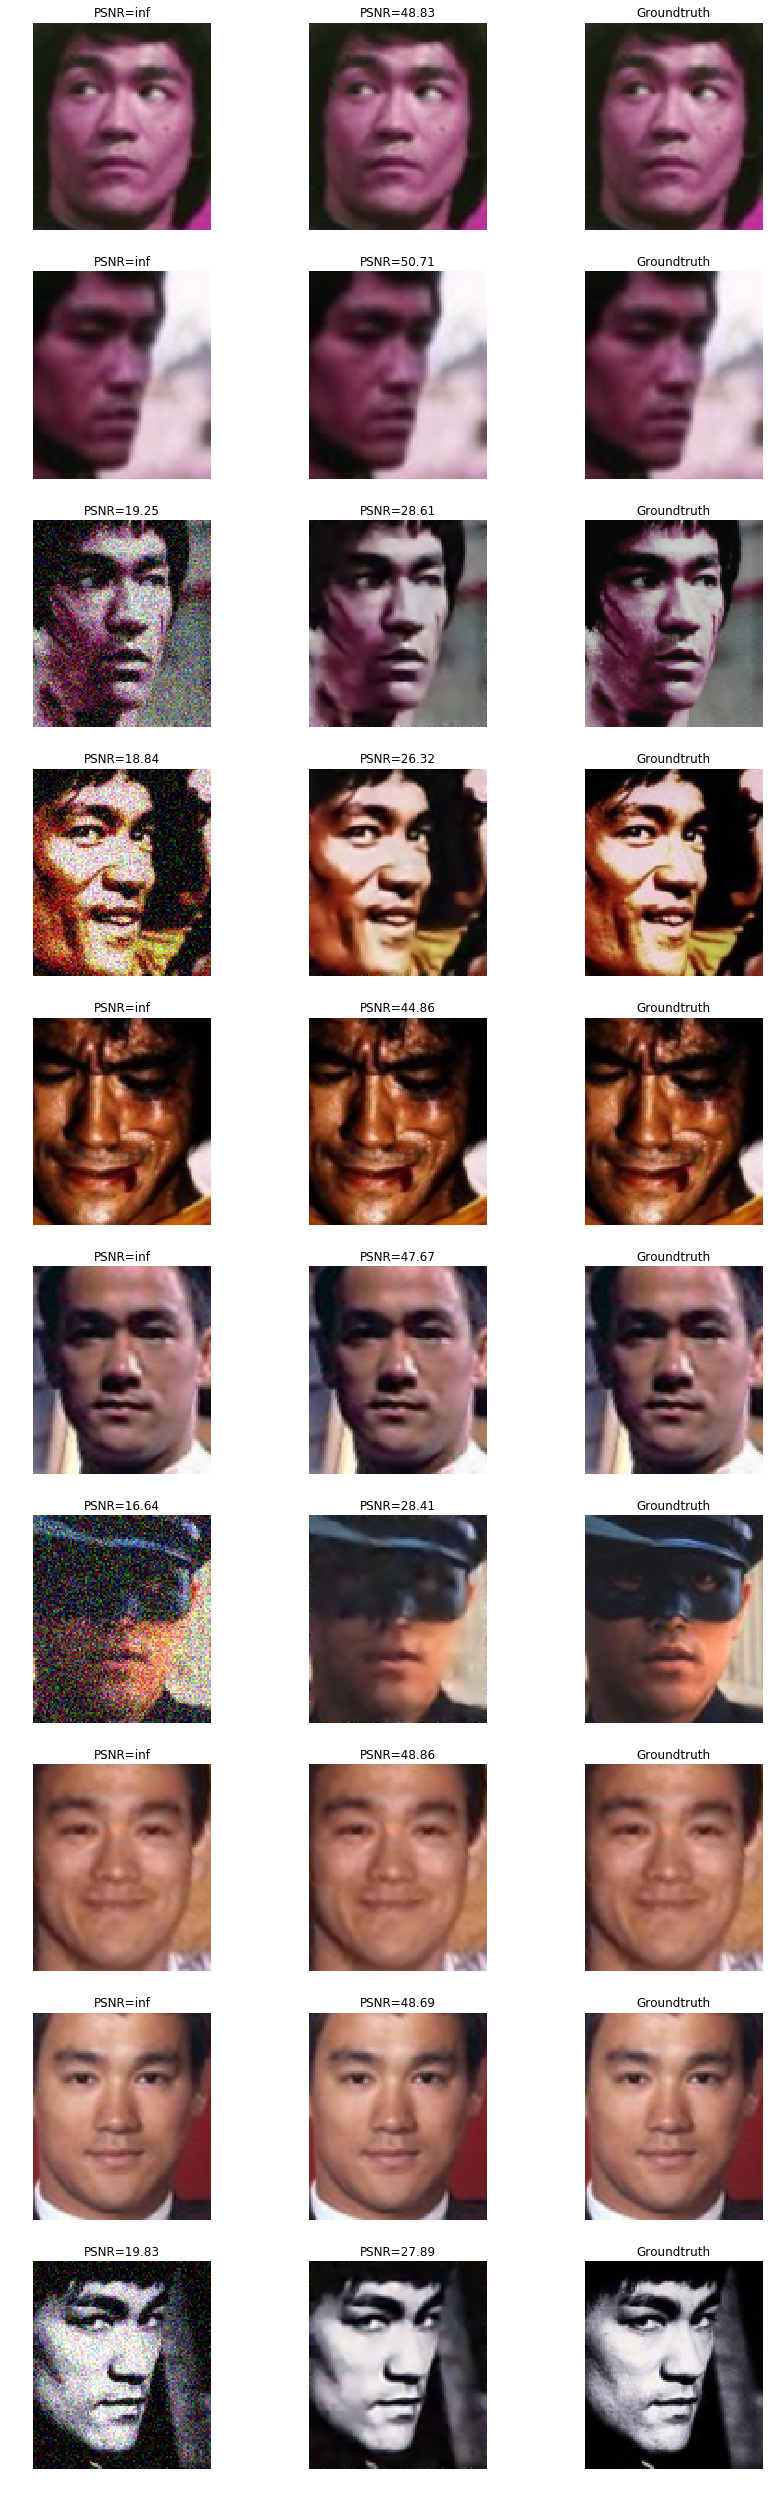

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
def psnr(img1, img2, PIXEL_MAX):
    mse = np.mean( (img1.astype(np.float32) - img2.astype(np.float32)) ** 2 )
    if mse == 0:
        return np.inf
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

w = 14
h = 45

columns = 3
rows = batch_size
fig=plt.figure(figsize=(w, h))

for i in range(rows):
    fig.add_subplot(rows, columns, 1+i*columns)
    plt.imshow(noised[i])
    plt.axis('off')
    noised_psnr = psnr(noised[i], groundtruth[i], PIXEL_MAX=255)
    plt.title("PSNR=%.2f" % noised_psnr)
    
    fig.add_subplot(rows, columns, 1+i*columns+1)
    plt.imshow(denoised[i])
    plt.axis('off')
    denoised_psnr = psnr(denoised[i], groundtruth[i], PIXEL_MAX=255)
    plt.title("PSNR=%.2f" % denoised_psnr)
       
    fig.add_subplot(rows, columns, 1+i*columns+2)
    plt.imshow(groundtruth[i])
    plt.axis('off')
    plt.title("Groundtruth")

In [7]:
import tqdm
import queue
import threading
from PIL import Image
import numpy as np

num_worker_threads = 10

q_denoised = queue.Queue()
q_noised = queue.Queue()
threads_denoised = []
threads_noised = []

def do_work(img, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    Image.fromarray(img.clip(0,255).astype(np.uint8)).save(path)

class ImageSaver(threading.Thread):
    def __init__(self, q, output_path):
        threading.Thread.__init__(self)
        self.q = q
        self.output_path = output_path
        
    def run(self):
        while True:
            item = self.q.get()
            if item is None:
                break
            img, path = item
            path = os.path.join(self.output_path, path)
            do_work(img, path)
            self.q.task_done()

In [8]:
from datasets.noised import NoisedDataset_w_dirs

high_noise_std_arr = (np.arange(30, 55, 4)/255).tolist()

train_data_dir = "/home/safin/datasets/CASIA-WebFace/CASIA-WebFace-sphereface/"
transform = transforms.Compose([
                         transforms.RandomCrop((112,96)),
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor()
                     ])
noised_dataset = NoisedDataset_w_dirs(train_data_dir, transform=transform, noise_transform=GaussianNoise(std=high_noise_std_arr, threshold=0.7))

batch_size = 64
dataloader_casia = torch.utils.data.dataloader.DataLoader(noised_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=16)

for i in range(num_worker_threads):
    t = ImageSaver(q_denoised, "/home/safin/datasets/CASIA-WebFace/1st_udnet7pa_output/")
    t.start()
    threads_denoised.append(t)
    
for i in range(num_worker_threads):
    t = ImageSaver(q_noised, "/home/safin/datasets/CASIA-WebFace/1st_udnet7pa_input/")
    t.start()
    threads_noised.append(t)

In [9]:
import sys
sys.path.append("/home/safin/")
from pydl import utils as pydlutil

denoiser.eval()
denoiser.train(False)

import time

t_start = time.time()
for batch_idx, sample in tqdm.tqdm_notebook(enumerate(dataloader_casia)):
    noised, groundtruth, _, paths = sample
    noised, groundtruth = noised.cuda(), groundtruth.cuda()
    sigma = pydlutil.wmad_estimator(noised)
    sigma = sigma.cuda()
    denoised = denoiser(noised, sigma)

    for t in zip(denoised.permute(0, 2, 3, 1).cpu().data.numpy(), paths):
        q_denoised.put_nowait(t)
        
    for t in zip(noised.permute(0, 2, 3, 1).cpu().data.numpy(), paths):
        q_noised.put_nowait(t)

q_noised.join()
for i in range(num_worker_threads):
    q_noised.put(None)
    
q_denoised.join()
for i in range(num_worker_threads):
    q_denoised.put(None)

for t in threads_noised:
    t.join()
    
for t in threads_denoised:
    t.join()


t_end = time.time()
print(t_end-t_start)


1670.7173216342926


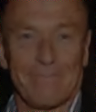

In [16]:
Image.open("/tmp/1st_udnet7pa_output/0000929/057.png")

In [17]:
denoised[0]

tensor([[[ 50.5539,   9.8163,  46.4437,  ...,  48.6909,  31.4932,  21.7835],
         [ 14.9313,  49.0610,  18.2568,  ...,  38.0528,  33.0241,  88.4904],
         [ 19.6012,  44.6934,  29.5162,  ...,  43.5135,  41.5585,  34.2520],
         ...,
         [179.2119, 203.4354, 195.0148,  ...,  46.1055,  41.7875,  55.4943],
         [182.4087, 205.7229, 196.2867,  ...,  57.4652,  64.0383,  22.4483],
         [234.8462, 148.2453, 254.8239,  ...,  47.8676,  46.5695, 119.9620]],

        [[ 98.2067,  45.8635,  30.0969,  ...,  20.4397,  31.7839,  52.8443],
         [ 46.6695,  47.2094,  38.8844,  ...,  40.1267,  36.7017,  26.2938],
         [ 41.0558,  53.1130,  48.2152,  ...,  48.6340,  41.2872,  32.2107],
         ...,
         [ 50.4121,  43.9883,  52.8804,  ...,  38.4984,  43.2581,  44.6068],
         [ 57.7725,  35.5150,  43.8840,  ...,  59.2010,  40.7702,  44.6427],
         [ 26.3669,  39.3603,  15.9106,  ...,  62.6460,  47.1137,  11.0624]],

        [[ 33.6806,   4.8220,  28.9872,  ...